# Tutorial 2: Training a spiking neural network on a simple vision dataset

Friedemann Zenke (https://fzenke.net)

> For more details on surrogate gradient learning, please see: 
> Neftci, E.O., Mostafa, H., and Zenke, F. (2019). Surrogate Gradient Learning in Spiking Neural Networks.
> https://arxiv.org/abs/1901.09948

In Tutorial 1, we have seen how to train a simple multi-layer spiking neural network on a small synthetic dataset. In this tutorial, we will apply what we have learned so far to a slightly larger dataset.
Concretely, we will use the [Fashion MNIST dataset](https://github.com/zalandoresearch/fashion-mnist). 

In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

import torch
import torch.nn as nn
import torchvision

In [2]:
torch.__version__

'2.4.0'

In [3]:
# The coarse network structure is dicated by the Fashion MNIST dataset. 
nb_inputs  = 28*28  # 입력 뉴런, 28x28 이미지 픽셀
nb_hidden  = 100    # 은닉층 뉴런
nb_outputs = 10     # 출력 뉴런, 0~9 넘버링된 패션 이미지

time_step = 1e-3    # 시간 단위 0.0001
nb_steps  = 100     # 시뮬레이션 시간, 100 시간 동안 시뮬레이션, 0.0001 x 100 총 0.1초 시뮬레이션

batch_size = 256    # 배치크기 지정

In [4]:
dtype = torch.float                 # 데이터 타입 지정

# Check whether a GPU is available
if torch.cuda.is_available():
    device = torch.device("cuda")     
else:
    device = torch.device("cpu")

device

device(type='cpu')

In [5]:
# Here we load the Dataset
# MNIST 데이터 로딩
root = os.path.expanduser("~/data/datasets/torch/fashion-mnist")
train_dataset = torchvision.datasets.FashionMNIST(root, train=True, transform=None, target_transform=None, download=True)   # 훈련데이터 불러오기
test_dataset = torchvision.datasets.FashionMNIST(root, train=False, transform=None, target_transform=None, download=True)   # 테스트데이터 불러오기

In [6]:
train_dataset, test_dataset

(Dataset FashionMNIST
     Number of datapoints: 60000
     Root location: /Users/leeingyu/data/datasets/torch/fashion-mnist
     Split: Train,
 Dataset FashionMNIST
     Number of datapoints: 10000
     Root location: /Users/leeingyu/data/datasets/torch/fashion-mnist
     Split: Test)

In [7]:
# Standardize data
# x_train = torch.tensor(train_dataset.train_data, device=device, dtype=dtype)
x_train = np.array(train_dataset.data, dtype=float)
x_train = x_train.reshape(x_train.shape[0], -1)/255 # 데이터 0~1 표준 정규화
# x_test = torch.tensor(test_dataset.test_data, device=device, dtype=dtype)
x_test = np.array(test_dataset.data, dtype=float)
x_test = x_test.reshape(x_test.shape[0], -1)/255

# y_train = torch.tensor(train_dataset.train_labels, device=device, dtype=dtype)
# y_test  = torch.tensor(test_dataset.test_labels, device=device, dtype=dtype)
y_train = np.array(train_dataset.targets, dtype=int)
y_test  = np.array(test_dataset.targets, dtype=int)

In [8]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((60000, 784), (60000,), (10000, 784), (10000,))

(-0.5, 27.5, 27.5, -0.5)

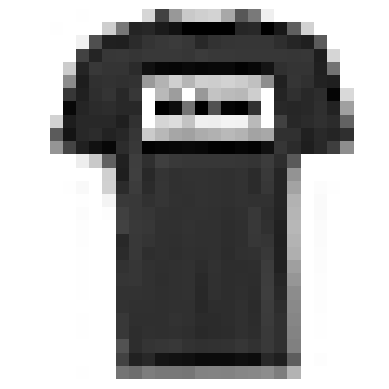

In [9]:
# Here we plot one of the raw data points as an example
data_id = 1
plt.imshow(x_train[data_id].reshape(28,28), cmap=plt.cm.gray_r)
plt.axis("off")

Since we are working with spiking neural networks, we ideally want to use a temporal code to make use of spike timing. To that end, we will use a spike latency code to feed spikes to our network.

In [10]:
def current2firing_time(x, tau=20, thr=0.2, tmax=1.0, epsilon=1e-7):
    """LIF 뉴런 모델에서 입력에 따라 첫번째 스파이크가 발생되는 시간 계산

    Args:
    x -- The "current" values, 현재 전류값

    Keyword args:
    tau -- The membrane time constant of the LIF neuron to be charged, 뉴런의 막전위가 증가되는 속도, 최소 속도 보장
    thr -- The firing threshold value, 스파이크 임계값, 스파이크 발생
    tmax -- The maximum time returned, 반환 최대 값, 시뮬레이션 step 값
    epsilon -- A generic (small) epsilon > 0, 0보다 큰 값으로 설정, 일반적으로 Division Error을 발생시키지 않기 위해 사용
    이 코드 상에서 최소값이 0을 방지하기 위해서 사용

    Returns:
    Time to first spike for each "current" x
    x에 대한 첫번째 스파이크 발생 시간
    """
    idx = x < thr
    x = np.clip(x, thr + epsilon, 1e9) # x: 입력값, thr+epsilon: 입력값이 가질 수 있는 최소값, 1e9: 입력값이 가질 수 있는 최대값
    T = tau * np.log(x / (x - thr))
    T[idx] = tmax

    # 값이 임계치보다 큰 인덱스 저장
    # 값을 특정 범위 (임계값 + 1e-7) ~ 1000000000.0
    # 로그 그래프 상으로 값을 표현
    # 로그 그래프 상으로 표현한 값에서 임계치보다 큰 값을 가지는 값은 최대값으로 지정

    return T

In [43]:
current2firing_time(x_train[0])

array([ 1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.  

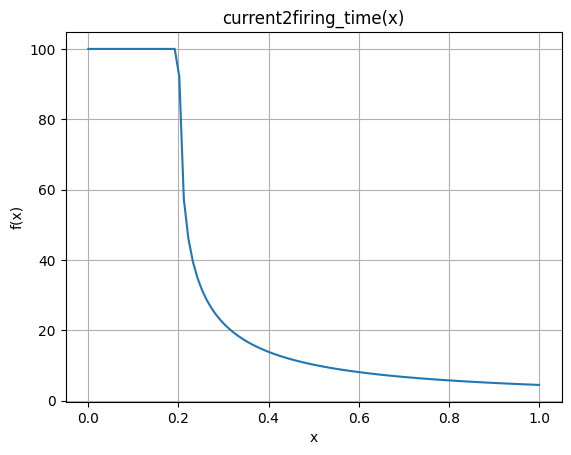

(100,)


0

In [97]:
import matplotlib.pyplot as plt
import numpy as np

# 2. x 축에 사용할 값 생성하기
x = np.linspace(0.0, 1.0, 100)  # -10에서 10까지 400개의 점 생성

# 4. 함수의 반환값 계산하기
y = current2firing_time(x, tau=20, thr=0.2, tmax=100, epsilon=1e-7)

# 5. 그래프 그리기
plt.plot(x, y)
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('current2firing_time(x)')
plt.grid(True)
plt.show()

print(y.shape)
np.argmax(y)

In [89]:
x = x_train[0:3]
print("x.shape:", x.shape)

output = current2firing_time(x, tau=20.0, thr=0.2, tmax=100)
print("output.shape:", output.shape)

output

x.shape: (3, 784)
output.shape: (3, 784)


array([[100., 100., 100., ..., 100., 100., 100.],
       [100., 100., 100., ..., 100., 100., 100.],
       [100., 100., 100., ..., 100., 100., 100.]])

In [94]:
print("output:", output[2])
c = output[2] < 100.0
print("c:", c)
output[2][c]

output: [100.         100.         100.         100.         100.
 100.         100.         100.         100.         100.
  11.3198401  100.         100.         100.         100.
 100.         100.         100.          17.32837804 100.
 100.         100.         100.         100.         100.
 100.         100.         100.         100.         100.
 100.         100.         100.         100.         100.
 100.         100.          14.26699776   5.50363819   5.72114753
   6.4503205    6.70711084   6.985411     6.40943791   6.13726263
   5.24728529   8.89935102  18.32581464 100.         100.
 100.         100.         100.         100.         100.
 100.         100.         100.         100.         100.
 100.         100.         100.         100.         100.
  18.32581464  22.23715031   5.92185102   5.14090206   4.60450035
   4.46287103   4.82324114   5.11498051   7.85613422  27.72588722
  20.29461609 100.         100.         100.         100.
 100.         100.         100. 

array([11.3198401 , 17.32837804, 14.26699776,  5.50363819,  5.72114753,
        6.4503205 ,  6.70711084,  6.985411  ,  6.40943791,  6.13726263,
        5.24728529,  8.89935102, 18.32581464, 18.32581464, 22.23715031,
        5.92185102,  5.14090206,  4.60450035,  4.46287103,  4.82324114,
        5.11498051,  7.85613422, 27.72588722, 20.29461609, 16.43960105,
       26.87469493, 16.43960105,  5.85339228,  5.33002501,  5.14090206,
        5.59478438,  7.79532397, 36.16577542, 15.8985975 , 24.64287363,
       20.74486685, 17.0210042 , 36.16577542, 39.96191804, 17.6477836 ,
       12.78159919, 22.78868566, 48.31827557, 22.23715031, 14.92139164,
       23.98833976, 22.78868566, 17.0210042 , 20.29461609, 20.29461609,
       28.64207794, 33.16456153, 23.98833976, 19.0620941 , 20.29461609,
       15.15371403, 24.64287363, 21.71417768, 17.32837804, 21.71417768,
       20.29461609, 19.0620941 , 19.0620941 , 19.0620941 , 19.0620941 ,
       19.86503546, 15.39374515, 22.23715031, 17.0210042 , 15.15

In [25]:
def sparse_data_generator(X, y, batch_size, nb_steps, nb_units, shuffle=True ):
    """ This generator takes datasets in analog format and generates spiking network input as sparse tensors. 
    이 제너레이트는 기본 데이터셋을 SNN에 맞게 변환시켜줍니다.

    Args:
        X: The data ( sample x event x 2 ) the last dim holds (time, neuron) tuples
        y: The labels
        X: 입력데이터, 마지막 차원은 (time, neuron) 이다.
        y: 출력데이터, 라벨데이터
    """

    """
    labels: 라벨 배열
    number_of_batches: 배치 크기
    sample_index: 입력데이터 인덱스 [0, 1, 2, ...]
    """
    labels_ = np.array(y, dtype=int)            # 라벨 상수 생성
    number_of_batches = len(X) // batch_size    # 배치 크기 생성
    sample_index = np.arange(len(X))            # 데이터의 인덱스로 쓰일 값

    # compute discrete firing times
    # 이산 스파이크 시간 계산
    tau_eff = 20e-3 / time_step

    # 값이 임계치보다 큰 인덱스 저장
    # 값을 특정 범위 (임계값 + 1e-7) ~ 1000000000.0
    # 로그 그래프 상으로 값을 표현
    # 로그 그래프 상으로 표현한 값에서 임계치보다 큰 값을 가지는 값은 최대값으로 지정
    firing_times = np.array(current2firing_time(X, tau=tau_eff, tmax=nb_steps), dtype=int)
    
    unit_numbers = np.arange(nb_units)

    # 데이터 셔플
    if shuffle:
        np.random.shuffle(sample_index)

    total_batch_count = 0
    counter = 0
    while counter < number_of_batches:
        batch_index = sample_index[batch_size * counter:batch_size * (counter+1)]

        coo = [ [] for i in range(3) ] # 배치, 시간, 유닛
        for bc, idx in enumerate(batch_index):
            c = firing_times[idx] < nb_steps    # 100이하일 경우 True, 100이면 False
            times, units = firing_times[idx][c], unit_numbers[c]    # 100 이하인 경우만 times에 저장, units에 인덱스(뉴런 번호) 저장

            batch = [bc for _ in range(len(times))]
            coo[0].extend(batch)
            coo[1].extend(times)
            coo[2].extend(units)

        i = torch.LongTensor(coo).to(device)    # coo(배치(0~시간 개수), 시간(100 이하), 유닛(100 이하인 뉴런 번호))이 저장된 
        v = torch.FloatTensor(np.ones(len(coo[0]))).to(device) # 1의 값을 가지며, coo[0]와 동일한 크기의 실수형 텐서 생성
    
        # 희소행렬(행렬상의 0을 생략하는 행렬) 생성: (비영향 요소의 위치, 기본 행렬, 희소 행렬 전체 크기)
        # 비영향 요소: 0이 아닌 요소
        X_batch = torch.sparse.FloatTensor(i, v, torch.Size([batch_size, nb_steps, nb_units])).to(device)
        y_batch = torch.tensor(labels_[batch_index], device=device)

        # 제너레이터 생성, yield를 통해 값이 사용된 후 다시 함수로 넘어와 작업 수행 후 yield에서 호출 대기
        yield X_batch.to(device=device), y_batch.to(device=device)

        counter += 1

In [58]:
20e-3 / time_step

20.0

In [100]:
generate_test = sparse_data_generator(x_train, y_train, batch_size, nb_steps, nb_inputs)
generate_test

<generator object sparse_data_generator at 0x17f8a5380>

In [104]:
test_value = next(generate_test)

In [109]:
test_value[0].shape

torch.Size([256, 100, 784])

In [117]:
test_value[0]

tensor(indices=tensor([[  0,   0,   0,  ..., 255, 255, 255],
                       [ 25,  15,  10,  ...,   8,   7,  25],
                       [ 10,  11,  12,  ..., 613, 614, 615]]),
       values=tensor([1., 1., 1.,  ..., 1., 1., 1.]),
       size=(256, 100, 784), nnz=83285, layout=torch.sparse_coo)

In [107]:
test_value[1]

tensor([0, 9, 5, 7, 7, 4, 2, 9, 1, 6, 1, 4, 4, 5, 8, 9, 1, 1, 4, 6, 2, 3, 3, 9,
        1, 6, 6, 6, 7, 8, 4, 8, 1, 5, 4, 9, 0, 3, 0, 5, 6, 9, 3, 4, 4, 0, 4, 4,
        6, 6, 5, 7, 4, 9, 9, 7, 1, 7, 5, 1, 2, 1, 2, 4, 7, 2, 0, 5, 6, 8, 5, 9,
        4, 6, 8, 8, 2, 6, 4, 1, 8, 3, 6, 4, 3, 1, 9, 7, 3, 3, 1, 1, 4, 1, 9, 9,
        5, 3, 0, 5, 3, 6, 8, 2, 6, 2, 2, 5, 6, 5, 9, 2, 8, 6, 4, 3, 2, 2, 8, 0,
        6, 0, 4, 8, 7, 4, 9, 7, 2, 4, 0, 9, 9, 7, 2, 8, 9, 4, 3, 3, 5, 9, 5, 8,
        4, 7, 2, 5, 0, 4, 3, 7, 1, 5, 5, 1, 9, 9, 6, 1, 4, 8, 9, 6, 4, 7, 1, 9,
        1, 1, 6, 5, 4, 0, 3, 7, 8, 9, 5, 7, 7, 9, 5, 4, 1, 3, 3, 3, 6, 2, 2, 2,
        1, 6, 1, 6, 7, 2, 1, 6, 6, 3, 6, 0, 0, 7, 3, 4, 2, 4, 0, 4, 8, 7, 9, 8,
        0, 7, 2, 9, 8, 9, 5, 9, 5, 0, 8, 3, 1, 4, 3, 4, 2, 9, 9, 0, 5, 4, 3, 3,
        3, 3, 7, 4, 5, 7, 0, 4, 2, 2, 3, 1, 8, 1, 5, 9])

### Setup of the spiking network model

In [32]:
tau_mem = 10e-3 # 막전위 변화율, 전류
tau_syn = 5e-3  # 시냅스 변화율, 전달 스파이크

alpha   = float(np.exp(-time_step/tau_syn)) # 알파 파라미터 지정
beta    = float(np.exp(-time_step/tau_mem)) # 베타 파라미터 지정

In [35]:
weight_scale = 7 * (1.0 - beta) # this should give us some spikes to begin with

# 입력층 -> 은닉층 가중치 초기화
w1 = torch.empty((nb_inputs, nb_hidden),  device=device, dtype=dtype, requires_grad=True)
torch.nn.init.normal_(w1, mean=0.0, std=weight_scale / np.sqrt(nb_inputs))

# 은닉층 -> 출력층 가중치 초기화
w2 = torch.empty((nb_hidden, nb_outputs), device=device, dtype=dtype, requires_grad=True)
torch.nn.init.normal_(w2, mean=0.0, std=weight_scale / np.sqrt(nb_hidden))

print(w1.shape, w2.shape)
print("init done")

torch.Size([784, 100]) torch.Size([100, 10])
init done


In [37]:
# 스파이크 발생을 그래프로 표현, (3,5) 총 15개를 동시에 확인 가능
def plot_voltage_traces(mem, spk=None, dim=(3,5), spike_height=5):
    gs=GridSpec(*dim)

    if spk is not None:
        dat = 1.0 * mem
        dat[spk > 0.0] = spike_height   # 스파이크 발생 확인, 높이 5로 지정
        dat = dat.detach().cpu().numpy()
    else:
        dat = mem.detach().cpu().numpy()

    for i in range(np.prod(dim)):
        if i==0:
            a0 = ax = plt.subplot(gs[i])
        else:
            ax = plt.subplot(gs[i], sharey=a0)
        ax.plot(dat[i])
        ax.axis("off")

We can now run this code and plot the output layer "membrane potentials" below. As desired, these potentials do not have spikes riding on them.

## Training the network

In [39]:
class SurrGradSpike(torch.autograd.Function):
    """
    Here we implement our spiking nonlinearity which also implements 
    the surrogate gradient. By subclassing torch.autograd.Function, 
    we will be able to use all of PyTorch's autograd functionality.
    Here we use the normalized negative part of a fast sigmoid 
    as this was done in Zenke & Ganguli (2018).
    """
    
    scale = 100.0 # controls steepness of surrogate gradient

    @staticmethod
    def forward(ctx, input):
        """ctx: 상태정보나 환경정보, 자동 미분을 처리해주는 커스텀 연산자
        In the forward pass we compute a step function of the input Tensor
        and return it. ctx is a context object that we use to stash information which 
        we need to later backpropagate our error signals. To achieve this we use the 
        ctx.save_for_backward method.
        """
        ctx.save_for_backward(input)
        out = torch.zeros_like(input)
        out[input > 0] = 1.0
        return out

    @staticmethod
    def backward(ctx, grad_output):
        """ctx: 상태정보나 환경정보, 자동 미분을 처리해주는 커스텀 연산자
        In the backward pass we receive a Tensor we need to compute the 
        surrogate gradient of the loss with respect to the input. 
        Here we use the normalized negative part of a fast sigmoid 
        as this was done in Zenke & Ganguli (2018).
        """
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        grad = grad_input / (SurrGradSpike.scale * torch.abs(input) + 1.0)**2
        return grad
    
# here we overwrite our naive spike function by the "SurrGradSpike" nonlinearity which implements a surrogate gradient
# SurrgateGradient 설정, 서로게이 기울기를 스파이크 함수로 지정
spike_fn  = SurrGradSpike.apply

In [40]:
def run_snn(inputs):
    h1 = torch.einsum("abc,cd->abd", (inputs, w1))
    syn = torch.zeros((batch_size,nb_hidden), device=device, dtype=dtype)
    mem = torch.zeros((batch_size,nb_hidden), device=device, dtype=dtype)

    mem_rec = []
    spk_rec = []

    # Compute hidden layer activity
    for t in range(nb_steps):
        mthr = mem - 1.0
        out = spike_fn(mthr)
        rst = out.detach() # We do not want to backprop through the reset

        new_syn = alpha*syn +h1[:,t]
        new_mem = (beta*mem +syn)*(1.0-rst)

        mem_rec.append(mem)
        spk_rec.append(out)
        
        mem = new_mem
        syn = new_syn

    mem_rec = torch.stack(mem_rec,dim=1)
    spk_rec = torch.stack(spk_rec,dim=1)

    # Readout layer
    h2= torch.einsum("abc,cd->abd", (spk_rec, w2))
    flt = torch.zeros((batch_size,nb_outputs), device=device, dtype=dtype)
    out = torch.zeros((batch_size,nb_outputs), device=device, dtype=dtype)
    out_rec = [out]
    for t in range(nb_steps):
        new_flt = alpha * flt +h2[:,t]
        new_out = beta*out +flt

        flt = new_flt
        out = new_out

        out_rec.append(out)

    out_rec = torch.stack(out_rec,dim=1)
    other_recs = [mem_rec, spk_rec]
    return out_rec, other_recs

In [41]:
def train(x_data, y_data, lr=2e-3, nb_epochs=10):
    params = [w1, w2]
    optimizer = torch.optim.Adam(params, lr=lr, betas=(0.9, 0.999))

    log_softmax_fn = nn.LogSoftmax(dim=1)
    loss_fn = nn.NLLLoss()
    
    loss_hist = []
    for e in range(nb_epochs):
        local_loss = []
        for x_local, y_local in sparse_data_generator(x_data, y_data, batch_size, nb_steps, nb_inputs):
            output, _ = run_snn(x_local.to_dense())
            m, _ = torch.max(output,1)
            log_p_y = log_softmax_fn(m)
            loss_val = loss_fn(log_p_y, y_local)

            optimizer.zero_grad()
            loss_val.backward()
            optimizer.step()
            local_loss.append(loss_val.item())

        mean_loss = np.mean(local_loss)
        print("Epoch %i: loss=%.5f"%(e+1, mean_loss))
        loss_hist.append(mean_loss)
        
    return loss_hist
        
        
def compute_classification_accuracy(x_data, y_data):
    """ Computes classification accuracy on supplied data in batches. 
    정확도 계산"""
    accs = []
    for x_local, y_local in sparse_data_generator(x_data, y_data, batch_size, nb_steps, nb_inputs, shuffle=False):
        output,_ = run_snn(x_local.to_dense())
        m,_= torch.max(output,1) # max over time
        _,am=torch.max(m,1)      # argmax over output units
        tmp = np.mean((y_local==am).detach().cpu().numpy()) # compare to labels
        accs.append(tmp)

    return np.mean(accs)

In [42]:
loss_hist = train(x_train, y_train, lr=2e-4, nb_epochs=30)

/var/folders/w6/j_sk5xf147b61k7bb5g6wbd40000gn/T/ipykernel_8415/3622802053.py:42: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:643.)
  X_batch = torch.sparse.FloatTensor(i, v, torch.Size([batch_size, nb_steps,nb_units])).to(device)


Epoch 1: loss=0.89808
Epoch 2: loss=0.52975
Epoch 3: loss=0.47719
Epoch 4: loss=0.44713
Epoch 5: loss=0.42127
Epoch 6: loss=0.40146
Epoch 7: loss=0.39035
Epoch 8: loss=0.37899
Epoch 9: loss=0.36643
Epoch 10: loss=0.35731
Epoch 11: loss=0.34836
Epoch 12: loss=0.34011
Epoch 13: loss=0.33436
Epoch 14: loss=0.32931
Epoch 15: loss=0.32065
Epoch 16: loss=0.31631
Epoch 17: loss=0.31271
Epoch 18: loss=0.30368
Epoch 19: loss=0.30226
Epoch 20: loss=0.29588
Epoch 21: loss=0.28970
Epoch 22: loss=0.28564
Epoch 23: loss=0.28021
Epoch 24: loss=0.27573
Epoch 25: loss=0.27209
Epoch 26: loss=0.26678
Epoch 27: loss=0.26254
Epoch 28: loss=0.25719
Epoch 29: loss=0.25475
Epoch 30: loss=0.25106


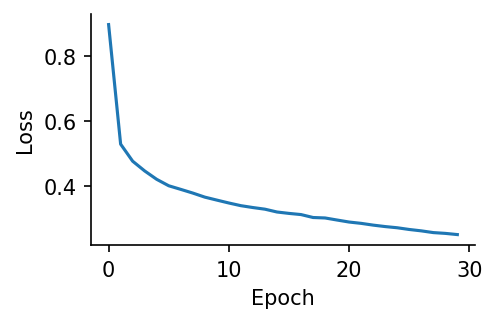

In [51]:
plt.figure(figsize=(3.3,2),dpi=150)
plt.plot(loss_hist)
plt.xlabel("Epoch")
plt.ylabel("Loss")
sns.despine()

In [52]:
print("Training accuracy: %.3f"%(compute_classification_accuracy(x_train,y_train)))
print("Test accuracy: %.3f"%(compute_classification_accuracy(x_test,y_test)))

Training accuracy: 0.914
Test accuracy: 0.865


In [53]:
def get_mini_batch(x_data, y_data, shuffle=False):
    for ret in sparse_data_generator(x_data, y_data, batch_size, nb_steps, nb_inputs, shuffle=shuffle):
        return ret 

In [54]:
x_batch, y_batch = get_mini_batch(x_test, y_test)
output, other_recordings = run_snn(x_batch.to_dense())
mem_rec, spk_rec = other_recordings

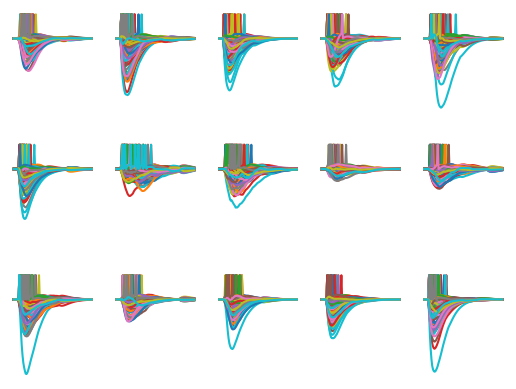

In [55]:
fig=plt.figure(dpi=100)
plot_voltage_traces(mem_rec, spk_rec)

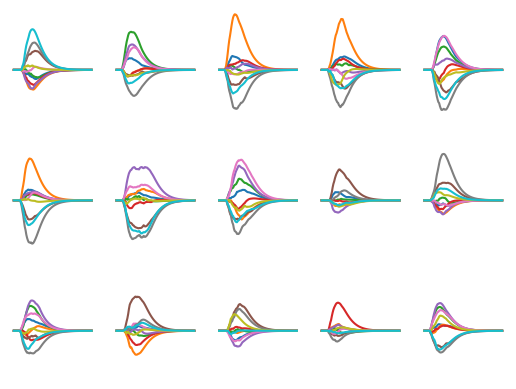

In [56]:
fig=plt.figure(dpi=100)
plot_voltage_traces(output)

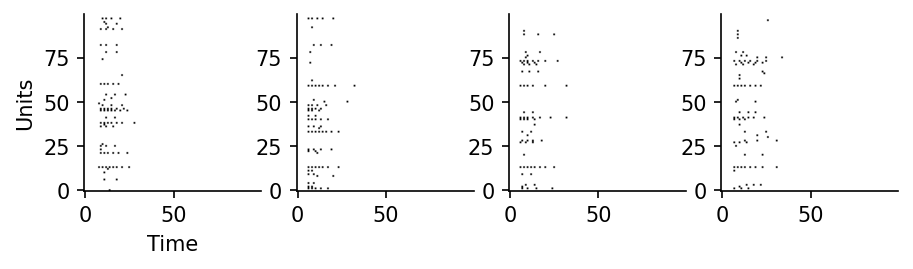

In [57]:
# Let's plot the hiddden layer spiking activity for some input stimuli

nb_plt = 4
gs = GridSpec(1,nb_plt)
fig= plt.figure(figsize=(7,3),dpi=150)
for i in range(nb_plt):
    plt.subplot(gs[i])
    plt.imshow(spk_rec[i].detach().cpu().numpy().T,cmap=plt.cm.gray_r, origin="lower" )
    if i==0:
        plt.xlabel("Time")
        plt.ylabel("Units")

    sns.despine()

In conclusion, we see that already this simple spiking network solves the classification problem with ~85% accuracy, and there is plenty of room left for tweaking. However, the hidden layer activities do not look very biological. Although the network displays population sparseness in that only a subset of neurons are active at any given time, the individual neurons' firing rates are pathologically high. This pathology is not too surprising since we have not incentivized low activity levels in any way. We will create such an incentive to address this issue by activity regularization in one of the next tutorials.

<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International License</a>.